(5071, 40)


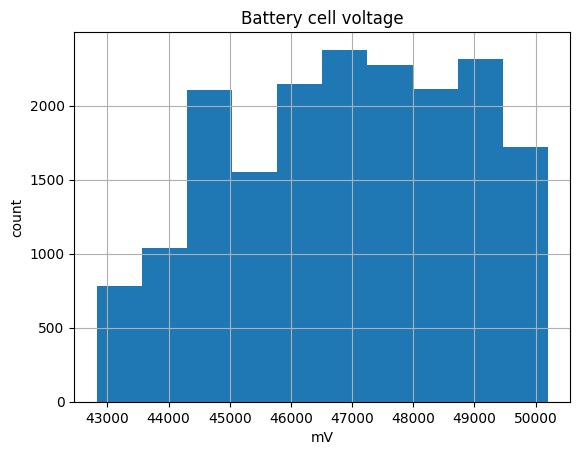

count    18424.000000
mean     46914.052866
std       1901.390125
min      42830.000000
25%      45360.000000
50%      47020.000000
75%      48520.000000
max      50200.000000
Name: ENS_Battery_cell_voltage, dtype: float64

In [1]:
# ACF plot of the normalized train subseries of the electric loads in Example 10.1
import nbimporter;
from UTILS.data_preprocessing_py import time_resampling_new 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

# # Завантаження даних з файлу
# data = pd.read_csv('data.csv')

FILE_NAME = '6000_frames_20221124+25_new'
PREDICT_PARAM = "ENS_Battery_cell_voltage"

TRAIN_COUNT = 5000#250
VALID_COUNT = 50
PREDICT_COUNT = 21

EPOHS = 100
BATCH_SIZE = 12

WINDOW=100 #MA
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        

# Завантаження даних
#data = pd.read_csv('data.csv')
# data = pd.read_csv('data/Origin_pkl/'+FILE_NAME + '.pkl', parse_dates=['Timestamp'])#, index_col='Timestamp')
data = pd.read_csv('data/Origin_pkl/Data_2023/6000_frames_20230424.pkl', parse_dates=['source_ts'])
#data = data.loc[0:TRAIN_COUNT+VALID_COUNT+PREDICT_COUNT-1+n_steps,:]
data = data.loc[0:TRAIN_COUNT+VALID_COUNT+PREDICT_COUNT-1,:]
rainfall_data_matrix = pd.read_csv('data/Origin_pkl/Data_2023/6000_frames_20230424.pkl')#,

print(data.shape)
data.head()
rainfall_data_matrix.loc[:,PREDICT_PARAM].hist()
plt.xlabel('mV')
plt.ylabel('count')
plt.title('Battery cell voltage')
plt.show()
rainfall_data_matrix.loc[:,PREDICT_PARAM].describe()


In [2]:
new_df = pd.DataFrame()

tss = pd.to_datetime(rainfall_data_matrix['source_ts'])
    # tmp_column = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M:%S').values

    
new_df.loc[:,PREDICT_PARAM] = rainfall_data_matrix.loc[:,PREDICT_PARAM]
# new_df
# time_resampling(new_df, new_resampled_rate = '1T', ts_format = '%Y-%m-%d %H:%M:%S.%f')

In [3]:
import math 
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score, mean_absolute_percentage_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def mean_squared_persentage_error(y_true, y_pred):
    EPSILON =  1e-10 # Yes, Python is awesome and supports scientific notation!
    mspe = np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))
    return mspe

def root_mean_squared_persentage_error(y_true, y_pred):
    EPSILON =  1e-10 # Yes, Python is awesome and supports scientific notation!
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))) * 100
    return rmspe

def mean_forecast_error(y_true, y_pred):
    mfe = np.mean(y_true - y_pred)
    return mfe

def mean_bias_error(y_true, y_pred):
    mbe = np.sum(y_true - y_pred)/y_true.size
    return mbe

def systematic_error_BIAS(y_true, y_pred):
    bias = np.sum(y_true - y_pred)
    return bias

def max_error_(y_true, y_pred):
    me = max_error(y_true, y_pred)
    return me

def r2_e(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    return r2

In [4]:
def check_variance_mean_change(dataframe, column_name):
    column_data = dataframe[column_name]
    rolling_var = column_data.rolling(window=10).var()
    
    mean_var_ratio = rolling_var / rolling_var.mean()
    
    # Define a threshold for detecting variance changes
    threshold = 1.5
    
    # Check if the mean-variance ratio exceeds the threshold
    variance_changed = any(mean_var_ratio > threshold)
    
    rolling_mean = column_data.rolling(window=10).mean()
    mean_change = rolling_mean.diff().dropna()
    
    if variance_changed:
        print(f"Variance in column '{column_name}' changed over time.")
    else:
        print(f"Variance in column '{column_name}' is relatively stable over time.")    
    
    if mean_change.mean() != 0:
        print(f"Mean in column '{column_name}' changed over time.")
    else:
        print(f"Mean in column '{column_name}' is relatively stable over time.")
print(check_variance_mean_change(rainfall_data_matrix, PREDICT_PARAM))

Variance in column 'ENS_Battery_cell_voltage' changed over time.
Mean in column 'ENS_Battery_cell_voltage' changed over time.
None


ADF Statistic: 4.827674
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


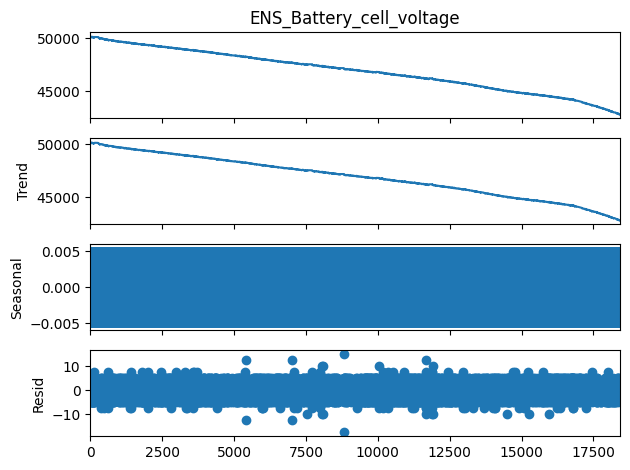

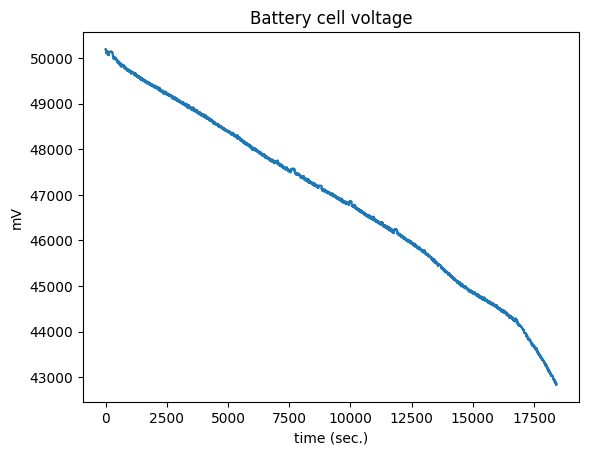

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import adfuller

parametr = rainfall_data_matrix["ENS_Battery_cell_voltage"]
check_stationarity(parametr)
# check_stationarity(new_df_2)

# data = rainfall_data_matrix["ENS_Battery_cell_voltage"]
# result = seasonal_decompose(rainfall_data_matrix["ENS_Battery_cell_voltage"], model='additive', period=1200)
result = seasonal_decompose(parametr, model='aditive', period=2)
result.plot()
pyplot.show()
estimated_trend_add = result.trend
estimated_seasonal_add = result.seasonal
estimated_residual_add = result.resid
# print(result.trend)
# result.trend.plot()
parametr.plot()
plt.xlabel('time (sec.)')
plt.ylabel('mV')
plt.title('Battery cell voltage')
plt.show()


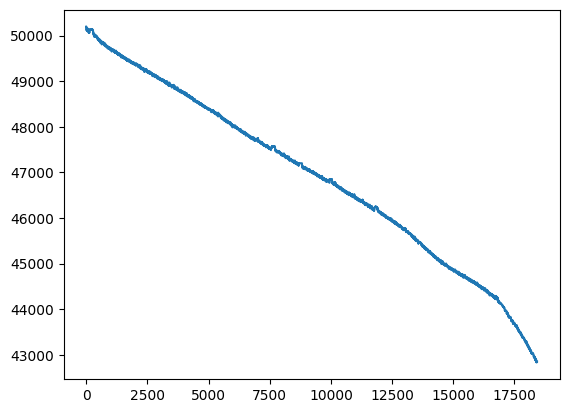

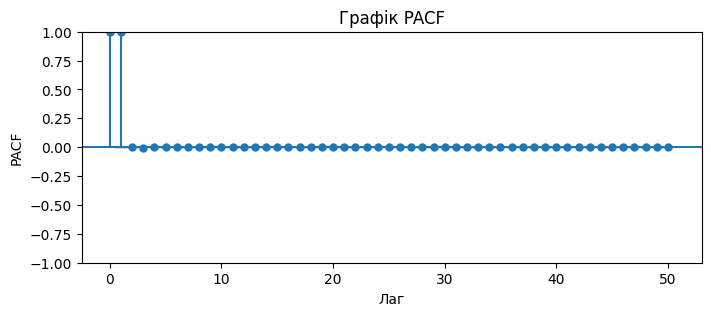

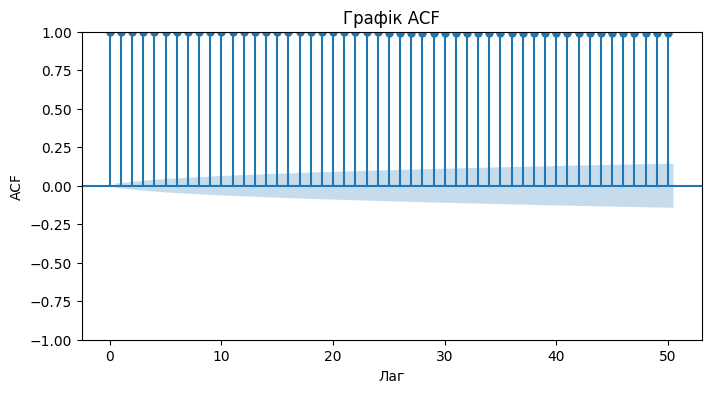

<bound method NDFrame.describe of 0        50190
1        50190
2        50200
3        50190
4        50190
         ...  
18419    42850
18420    42850
18421    42850
18422    42850
18423    42850
Name: ENS_Battery_cell_voltage, Length: 18424, dtype: int64>

In [6]:
# Будуємо графік PACF
parametr.plot()
plt.figure(figsize=(8, 3))
plot_pacf(rainfall_data_matrix['ENS_Battery_cell_voltage'].dropna(), lags=50, ax=plt.gca())
# plot_pacf(parametr.dropna)
plt.xlabel('Лаг')
plt.ylabel('PACF')
plt.title('Графік PACF')
plt.show()

# Будуємо графік ACF
plt.figure(figsize=(8, 4))
plot_acf(rainfall_data_matrix['ENS_Battery_cell_voltage'].dropna(), lags=50, ax=plt.gca())
# plot_acf(parametr.dropna)
plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.title('Графік ACF')
plt.show()
rainfall_data_matrix['ENS_Battery_cell_voltage'].describe

In [8]:
# def integration_time_series(time_series, initial_value):
#     cumulative_sum = time_series.cumsum()
#     integration_series = cumulative_sum + initial_value
#     return integration_series

# # original_series = reverse_diff(differentiated_df.loc[1:,'ENS_Battery_cell_voltage'] , rainfall_data_matrix["ENS_Battery_cell_voltage"][0])
# integration_series = integration_time_series(rainfall_data_matrix["ENS_Battery_cell_voltage"], rainfall_data_matrix["ENS_Battery_cell_voltage"][TRAIN_COUNT+VALID_COUNT+1])
# rainfall_data_matrix.loc[TRAIN_COUNT+VALID_COUNT+1:TRAIN_COUNT+VALID_COUNT+1+forecast_steps,'ENS_Battery_cell_voltage'].plot(label = 'integr')
# plt.xlabel('Дискретні відліки')
# plt.ylabel('Значення')
# plt.title('Графік інтегрованого часового ряду')
# original_series.plot(label = 'origin')
# plt.show()
# check_stationarity(integration_series)
rainfall_data_matrix["ENS_Battery_cell_voltage"]

0        50190
1        50190
2        50200
3        50190
4        50190
         ...  
18419    42850
18420    42850
18421    42850
18422    42850
18423    42850
Name: ENS_Battery_cell_voltage, Length: 18424, dtype: int64


Результат першого диференціювання:


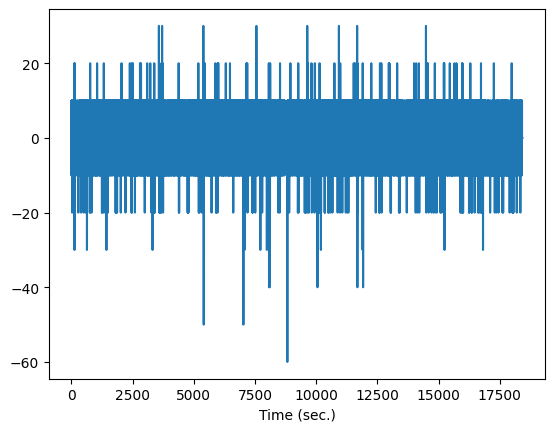

ADF Statistic: -30.312010
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
Variance in column 'ENS_Battery_cell_voltage' changed over time.
Mean in column 'ENS_Battery_cell_voltage' changed over time.
None


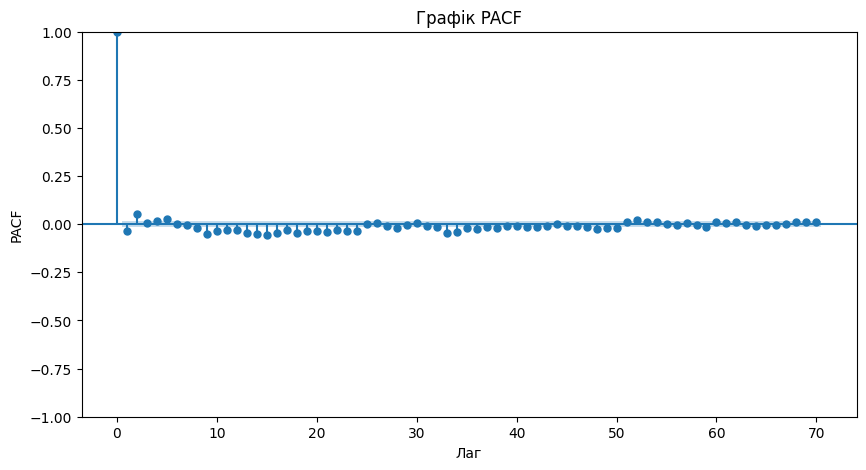

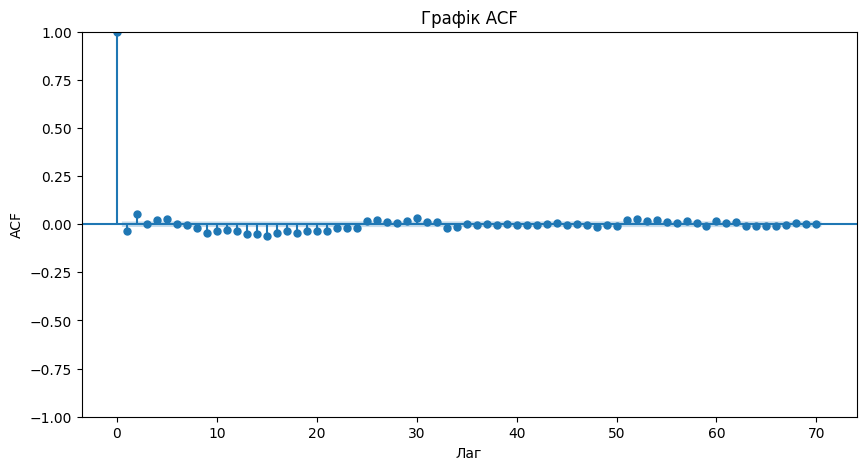

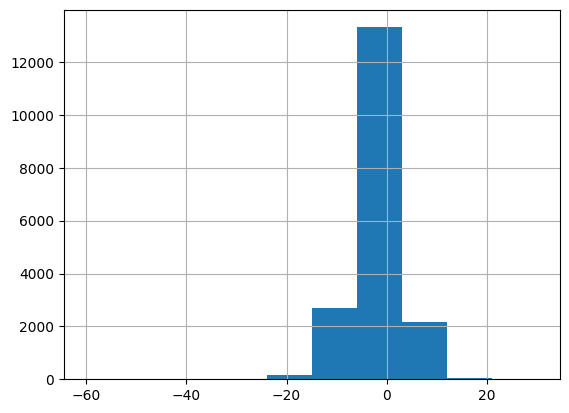

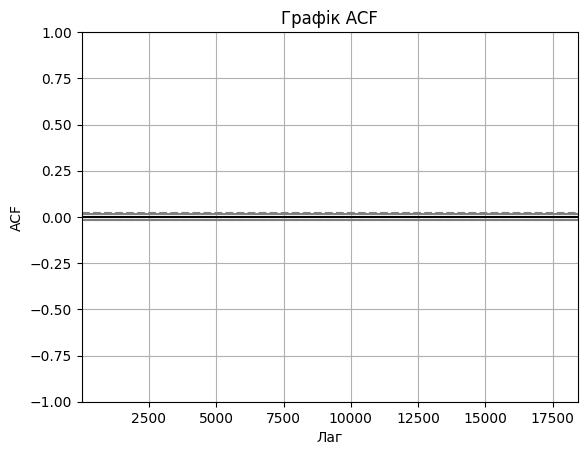

count    18423.000000
mean        -0.398415
std          5.732974
min        -60.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: ENS_Battery_cell_voltage, dtype: float64


In [7]:
from pandas.plotting import autocorrelation_plot
def differentiate_time_series(df, column_name, order=1):
    differentiated_series = df[column_name].diff(periods=order)
    differentiated_df = df.copy()
    differentiated_df[column_name] = differentiated_series

    return differentiated_df

# Застосуємо перше диференціювання
differentiated_df = differentiate_time_series(rainfall_data_matrix, column_name='ENS_Battery_cell_voltage', order=1)
# differentiated_df = differentiate_time_series(parametr, column_name='ENS_Battery_cell_voltage', order=1)
print("\nРезультат першого диференціювання:")
# print(differentiated_df['ENS_Battery_cell_voltage'])
differentiated_df['ENS_Battery_cell_voltage'].plot()
plt.xlabel('Time (sec.)')
# plt.ylabel('mW')
# plt.title('Графік PACF')
plt.show()

tmp = pd.DataFrame()
tmp.loc[1:,'ENS_Battery_cell_voltage'] = differentiated_df.loc[:,'ENS_Battery_cell_voltage'].values

check_stationarity(tmp.loc[1:,'ENS_Battery_cell_voltage'])
print(check_variance_mean_change(tmp, PREDICT_PARAM))
# tmp
# Будуємо графік PACF
plt.figure(figsize=(10, 5))
plot_pacf(differentiated_df['ENS_Battery_cell_voltage'].dropna(), lags=70, ax=plt.gca())
# plot_pacf(parametr.dropna)
plt.xlabel('Лаг')
plt.ylabel('PACF')
plt.title('Графік PACF')
plt.show()

# Будуємо графік ACF
plt.figure(figsize=(10, 5))
plot_acf(differentiated_df['ENS_Battery_cell_voltage'].dropna(), lags=70, ax=plt.gca())
# plot_acf(parametr.dropna)
plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.title('Графік ACF')
plt.show()

# histogram plot
differentiated_df['ENS_Battery_cell_voltage'].hist()
pyplot.show()

# autocorrelation
autocorrelation_plot(differentiated_df['ENS_Battery_cell_voltage'])
plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.title('Графік ACF')
pyplot.show()
print(differentiated_df['ENS_Battery_cell_voltage'].describe())

# result = seasonal_decompose(differentiated_df['ENS_Battery_cell_voltage'], model='aditive', period=2)
# result.plot()
# pyplot.show()
# estimated_trend_add = result.trend
# estimated_seasonal_add = result.seasonal
# estimated_residual_add = result.resid


Результат другого диференціювання:
ADF Statistic: -39.469838
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
count    18422.00000
mean         0.00000
std          8.24151
min        -60.00000
25%          0.00000
50%          0.00000
75%          0.00000
max         70.00000
Name: ENS_Battery_cell_voltage, dtype: float64


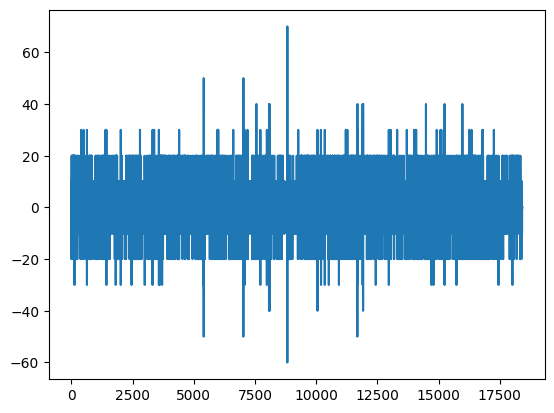

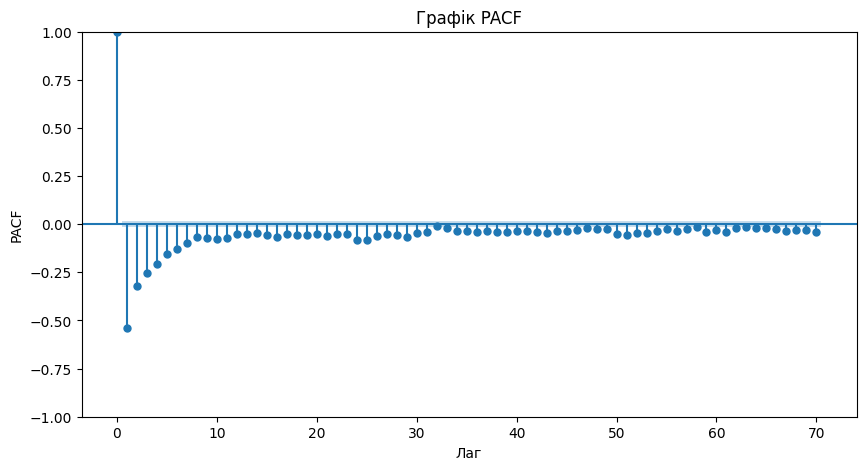

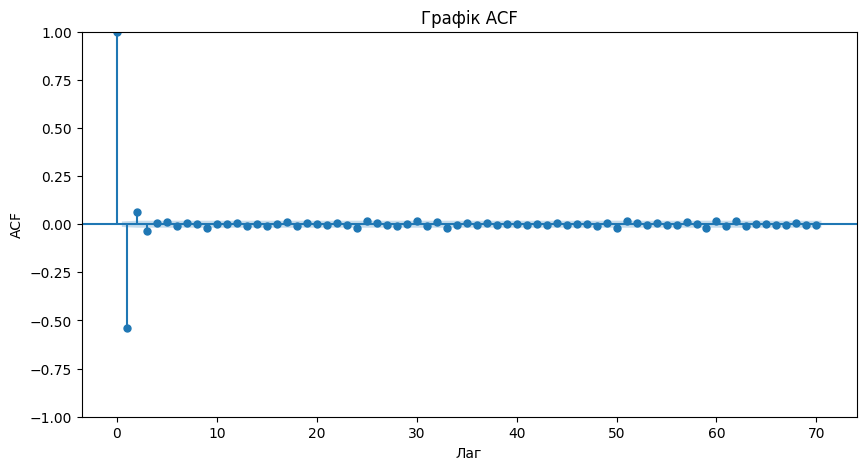

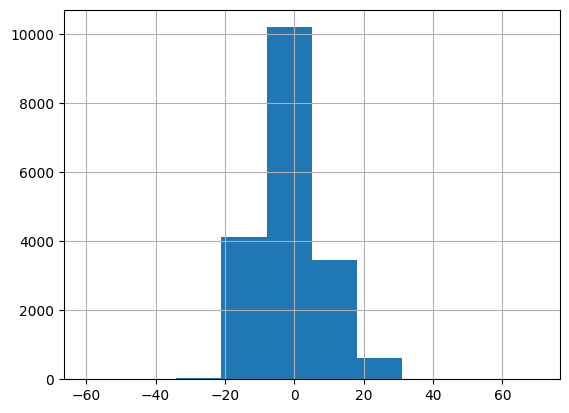

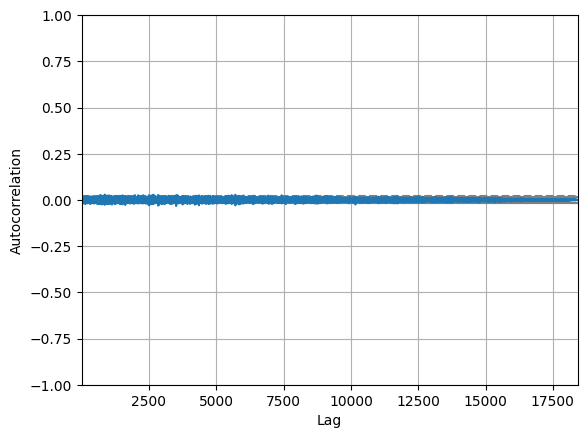

In [8]:
differentiated_df_2 = differentiate_time_series(differentiated_df, column_name='ENS_Battery_cell_voltage', order=1)
# differentiated_df = differentiate_time_series(parametr, column_name='ENS_Battery_cell_voltage', order=1)
print("\nРезультат другого диференціювання:")
# print(differentiated_df['ENS_Battery_cell_voltage'])
differentiated_df_2.loc[2:,'ENS_Battery_cell_voltage'].plot()
# differentiated_df_2.loc[2:,'ENS_Battery_cell_voltage']
tmp1 = pd.DataFrame()
tmp1 = differentiated_df_2.loc[2:,'ENS_Battery_cell_voltage']
check_stationarity(tmp1)
# print(check_variance_mean_change(tmp1, PREDICT_PARAM))
print(tmp1.describe())

# Будуємо графік PACF
plt.figure(figsize=(10, 5))
plot_pacf(tmp1.dropna(), lags=70, ax=plt.gca())
# plot_pacf(parametr.dropna)
plt.xlabel('Лаг')
plt.ylabel('PACF')
plt.title('Графік PACF')
plt.show()

# Будуємо графік ACF
plt.figure(figsize=(10, 5))
plot_acf(tmp1.dropna(), lags=70, ax=plt.gca())
# plot_acf(parametr.dropna)
plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.title('Графік ACF')
plt.show()

# histogram plot
tmp1.hist()
pyplot.show()

# autocorrelation
autocorrelation_plot(tmp1)
pyplot.show()



In [10]:
# # example of ARCH model
# from random import gauss
# from random import seed
# from matplotlib import pyplot
# from arch import arch_model
# # seed pseudorandom number generator
# seed(1)
# # create dataset
# # data = [gauss(0, i*0.01) for i in range(0,100)]
# data = differentiated_df['ENS_Battery_cell_voltage'].dropna()
# # split into train/test
# n_test = 100
# train, test = data[:-n_test], data[-n_test:]
# # define model
# model = arch_model(train, mean='Zero', vol='GARCH', p=100, q=200)
# # fit model
# model_fit = model.fit()
# # forecast the test set
# yhat = model_fit.forecast(horizon=n_test)
# # plot the actual variance
# var = [i*0.01 for i in range(0,100)]
# pyplot.plot(var[-n_test:])
# # plot forecast variance
# pyplot.plot(yhat.variance.values[-1, :])
# pyplot.show()

In [23]:
# print(len(differentiated_df),' ',len(smoothed_data))
# # differentiated_df.loc[1,'ENS_Battery_cell_voltage']
# tmp.loc[3:,'ENS_Battery_cell_voltage']
# # tmp

In [13]:

window_size = 100
smoothed_data = moving_average(differentiated_df.values, window_size)
plt.figure(figsize=(10, 6))
plt.plot( tmp, label='Оригінальні дані')
plt.xlabel('Час')
plt.ylabel('Значення')

plt.plot( smoothed_data, label=f'МА (вікно = {window_size})')
plt.legend()
plt.title('Згладжування методом ковзного середнього')
plt.grid(True)
plt.show()

new_aver_sign = pd.DataFrame()
tmp_array = [];
for r,i in enumerate(range(window_size, len(smoothed_data) - 1)):
    # print(tmp.loc[i,'ENS_Battery_cell_voltage']-smoothed_data[i], ' ',tmp.loc[i,'ENS_Battery_cell_voltage'],' ',smoothed_data[i],' ', i)
    # new_aver_sign.ENS_Battery_cell_voltage = tmp.loc[i,'ENS_Battery_cell_voltage']-smoothed_data[i]
    
    # new_aver_sign.loc[i,'ENS_Battery_cell_voltage'] = str(tmp.loc[i+1,'ENS_Battery_cell_voltage']-smoothed_data[i])
    tmp_array.append(tmp.loc[i,'ENS_Battery_cell_voltage']-smoothed_data[r])
new_aver_sign['ENS_Battery_cell_voltage'] = tmp_array;
    
print(new_aver_sign.ENS_Battery_cell_voltage)    
plt.plot(new_aver_sign.ENS_Battery_cell_voltage, label = ' centered')
plt.xlabel('Час')
plt.ylabel('Значення')
plt.grid(True)
plt.show()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [14]:
check_stationarity(new_aver_sign.loc[1:,'ENS_Battery_cell_voltage'])
# new_aver_sign.loc[1:,'ENS_Battery_cell_voltage']


NameError: name 'new_aver_sign' is not defined

In [ ]:
def reverse_diff(diff_series, initial_value):
    cumulative_sum = pd.Series(diff_series).cumsum()
    original_series = cumulative_sum + initial_value
    return original_series

smoothed_data
# original_series = reverse_diff(differentiated_df.loc[1:,'ENS_Battery_cell_voltage'] , rainfall_data_matrix["ENS_Battery_cell_voltage"][0])
original_series = reverse_diff(smoothed_data, rainfall_data_matrix.loc[0,"ENS_Battery_cell_voltage"])
# rainfall_data_matrix.loc[TRAIN_COUNT+VALID_COUNT+1:TRAIN_COUNT+VALID_COUNT+1+forecast_steps,'ENS_Battery_cell_voltage'].plot()
# original_series.plot()
# plt.show()


In [ ]:
new_aver_sign.loc[1:,'ENS_Battery_cell_voltage']

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.api as sm
# # Побудова ARIMA моделі
# # Нестаціонарний порядок (p, d, q)
# # model_ARIMA = sm.tsa.ARIMA(differentiated_df.loc[1:TRAIN_COUNT+VALID_COUNT+1,'ENS_Battery_cell_voltage'], order=order)
# model_ARIMA = sm.tsa.ARIMA(new_aver_sign.loc[1:300,'ENS_Battery_cell_voltage'], order=(2, 1, 1))
# model_fit = model_ARIMA.fit()
# # Виведення результатів моделі
# print(model_fit.summary())

# # Побудова прогнозу на наступні 10 спостережень
# forecast_steps = 20
# forecast = model_fit.forecast(steps=forecast_steps)

# print("Прогнозні значення:")
# print(forecast)

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.api as sm
# # Побудова ARIMA моделі
# order = (3, 2, 2)  # Нестаціонарний порядок (p, d, q)
# # model_ARIMA = sm.tsa.ARIMA(differentiated_df.loc[1:TRAIN_COUNT+VALID_COUNT+1,'ENS_Battery_cell_voltage'], order=order)
# model_ARIMA = sm.tsa.ARIMA(differentiated_df.loc[1:TRAIN_COUNT+VALID_COUNT+1,'ENS_Battery_cell_voltage'], order=(3, 2, 2))
# model_fit = model_ARIMA.fit()
# # Виведення результатів моделі
# print(model_fit.summary())

# # Побудова прогнозу на наступні 10 спостережень
# forecast_steps = 120
# forecast = model_fit.forecast(steps=forecast_steps)

# print("Прогнозні значення:")
# print(forecast)



In [ ]:
forecast.plot()
differentiated_df.loc[1:TRAIN_COUNT+VALID_COUNT+1,'ENS_Battery_cell_voltage'].plot()

plt.show()

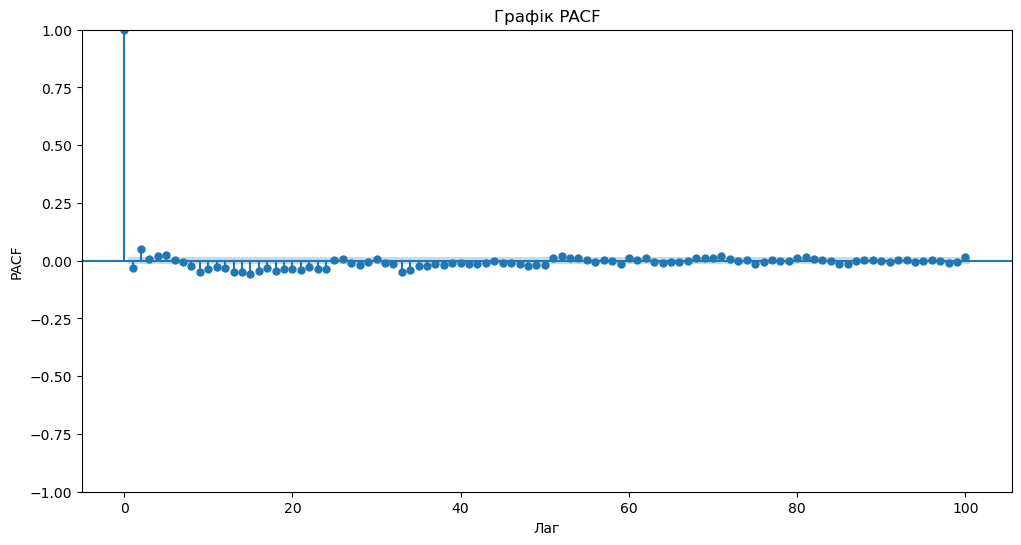

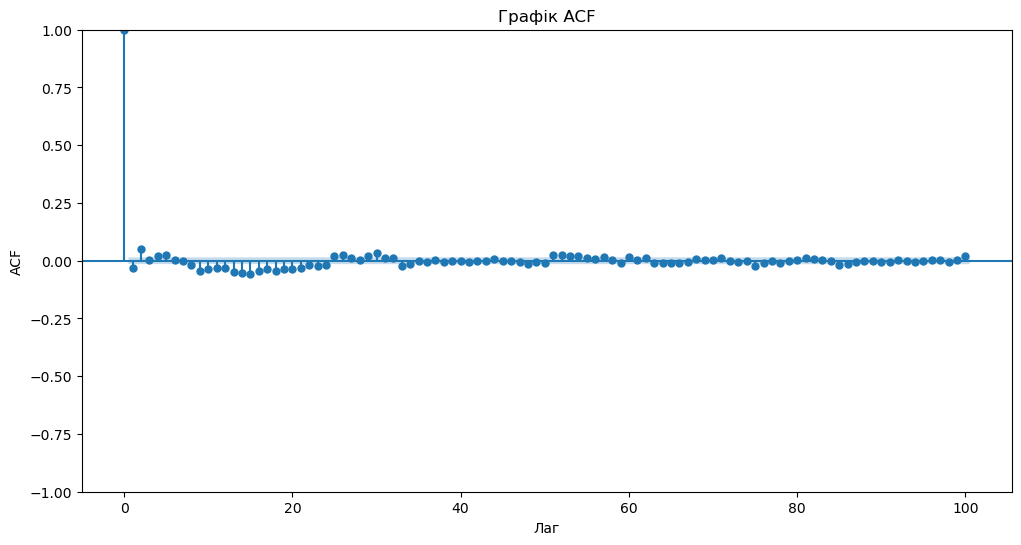

In [10]:
# Будуємо графік PACF
plt.figure(figsize=(12, 6))
plot_pacf(differentiated_df['ENS_Battery_cell_voltage'].dropna(), lags=100, ax=plt.gca())
plt.xlabel('Лаг')
plt.ylabel('PACF')
plt.title('Графік PACF')
plt.show()

# Будуємо графік ACF
plt.figure(figsize=(12, 6))
plot_acf(differentiated_df['ENS_Battery_cell_voltage'].dropna(), lags=100, ax=plt.gca())
plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.title('Графік ACF')
plt.show()

In [18]:
def reverse_diff(diff_series, initial_value):
    cumulative_sum = diff_series.cumsum()
    original_series = cumulative_sum + initial_value
    return original_series

# original_series = reverse_diff(differentiated_df.loc[1:,'ENS_Battery_cell_voltage'] , rainfall_data_matrix["ENS_Battery_cell_voltage"][0])
original_series = reverse_diff(forecast, rainfall_data_matrix["ENS_Battery_cell_voltage"][TRAIN_COUNT+VALID_COUNT+1])
rainfall_data_matrix.loc[TRAIN_COUNT+VALID_COUNT+1:TRAIN_COUNT+VALID_COUNT+1+forecast_steps,'ENS_Battery_cell_voltage'].plot()
original_series.plot()
plt.show()

NameError: name 'forecast' is not defined

In [26]:
order = (1, 1, 1)          # Параметри для несезонної складової (p, d, q)
seasonal_order = (1, 1, 1, 12)   # Параметри для сезонної складової (P, D, Q, s)
model = sm.tsa.SARIMAX(differentiated_df.loc[1:TRAIN_COUNT+VALID_COUNT+1,'ENS_Battery_cell_voltage'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

# Виведення результатів моделі
print(model_fit.summary())

# Побудова прогнозу на наступні 10 спостережень
forecast_steps = 120
forecast = model_fit.forecast(steps=forecast_steps)

print("Прогнозні значення:")
print(forecast)
original_series = reverse_diff(forecast, rainfall_data_matrix["ENS_Battery_cell_voltage"][TRAIN_COUNT+VALID_COUNT+1])
rainfall_data_matrix.loc[TRAIN_COUNT+VALID_COUNT+1:TRAIN_COUNT+VALID_COUNT+1+forecast_steps,'ENS_Battery_cell_voltage'].plot()
original_series.plot()
plt.show()

NameError: name 'sm' is not defined

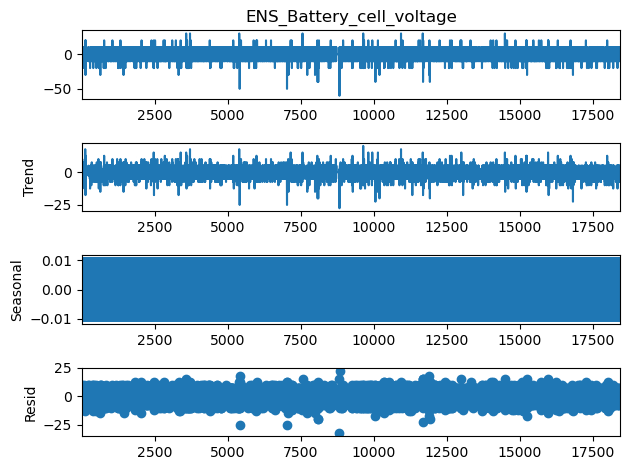

1             NaN
2        7.489279
3       -7.489279
4        4.989279
5       -4.989279
           ...   
18419    0.010721
18420   -0.010721
18421    0.010721
18422   -0.010721
18423         NaN
Name: resid, Length: 18423, dtype: float64


In [12]:
result = seasonal_decompose(differentiated_df.loc[1:,'ENS_Battery_cell_voltage'], model='additive', period=2)
result.plot()
pyplot.show()
estimated_trend_add = result.trend
estimated_seasonal_add = result.seasonal
estimated_residual_add = result.resid
print(estimated_residual_add)

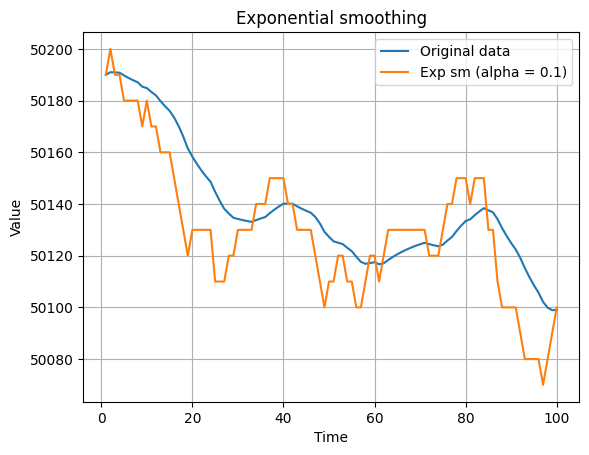

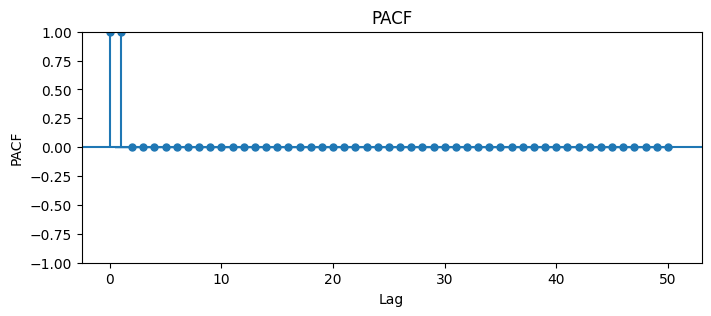

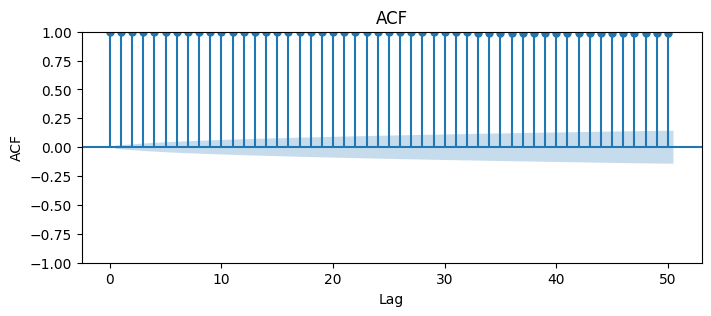

In [20]:
def exponential_smoothing(data, alpha):
    n = len(data)
    smoothed_data = [data[0]]  # Початкове значення рівне першому значенню у даних

    for i in range(1, n):
        smoothed_value = alpha * data[i] + (1 - alpha) * smoothed_data[-1]
        smoothed_data.append(smoothed_value)

    return smoothed_data

alpha = 0.1
data_exp_sm = rainfall_data_matrix[PREDICT_PARAM]
# print(smoothed_data)

smoothed_data = exponential_smoothing(data_exp_sm, alpha)
rainfall_data_matrix["ENS_Battery_cell_voltage_Exp_Sm"]= smoothed_data

# # data_exp_sm.plot()
# # rainfall_data_matrix["ENS_Battery_cell_voltage_Exp_Sm"].plot()
# plt.plot( rainfall_data_matrix["ENS_Battery_cell_voltage_Exp_Sm"], label='Оригінальні дані')
# plt.plot( data_exp_sm, label=f'Експ. згл (alpha = {alpha})')
# plt.legend()
# plt.xlabel('Час')
# plt.ylabel('Значення')
# plt.title('Експоненційне згладжування')

# # Будуємо графік PACF
# plt.figure(figsize=(10, 5))
# plot_pacf(smoothed_data, lags=20, ax=plt.gca())
# # plot_pacf(parametr.dropna)
# plt.xlabel('Лаг')
# plt.ylabel('PACF')
# plt.title('Графік PACF')
# plt.show()
# data_exp_sm.plot()
# rainfall_data_matrix["ENS_Battery_cell_voltage_Exp_Sm"].plot()
plt.plot( rainfall_data_matrix.loc[1:100,"ENS_Battery_cell_voltage_Exp_Sm"], label='Original data')
plt.plot( data_exp_sm.loc[1:100], label=f'Exp sm (alpha = {alpha})')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.title('Exponential smoothing')

# Будуємо графік PACF
plt.figure(figsize=(8, 3))
plot_pacf(smoothed_data, lags=50, ax=plt.gca())
# plot_pacf(parametr.dropna)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('PACF')
plt.show()

# Будуємо графік ACF
plt.figure(figsize=(8, 3))
plot_acf(smoothed_data, lags=50, ax=plt.gca())
# plot_acf(parametr.dropna)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('ACF')
plt.show()

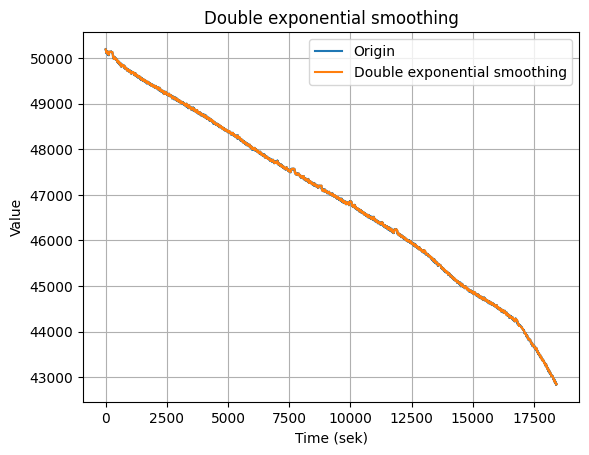

In [27]:
def double_exponential_smoothing(series, alpha, beta):
    # """
    # series: часовий ряд (один стовпець датафрейму)
    # alpha: коефіцієнт згладжування рівня
    # beta: коефіцієнт згладжування тренду
    # """
    
# smoothed_data = exponential_smoothing(data_exp_sm, alpha)
# іукшуі = rainfall_data_matrix[PREDICT_PARAM]
  

    result = []
    level = series[0]
    trend = series[1] - series[0]
    
    for t in range(len(series)):
        if t == 0:
            smoothed = series[t]
        elif t == 1:
            level = alpha * series[t] + (1 - alpha) * (level + trend)
            trend = beta * (level - series[t-1]) + (1 - beta) * trend
            smoothed = level + trend
        else:
            last_level = level
            level = alpha * series[t] + (1 - alpha) * (level + trend)
            trend = beta * (level - last_level) + (1 - beta) * trend
            smoothed = level + trend
        
        result.append(smoothed)
    
    return result

# Приклад використання
# data = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# df = pd.DataFrame(data, columns=['Value'])
df = rainfall_data_matrix[PREDICT_PARAM]

alpha = 0.2
beta = 0.01

smoothed_values = double_exponential_smoothing(rainfall_data_matrix[PREDICT_PARAM], alpha, beta)
# df['Smoothed'] = smoothed_values
smoothed_data = smoothed_values
# print(smoothed_values)
plt.plot( data_ma_sm, label='Origin')
plt.plot( smoothed_data, label='Double exponential smoothing')
plt.legend()
plt.xlabel('Time (sek)')
plt.ylabel('Value')
plt.title('Double exponential smoothing')
plt.grid(True)
plt.show()

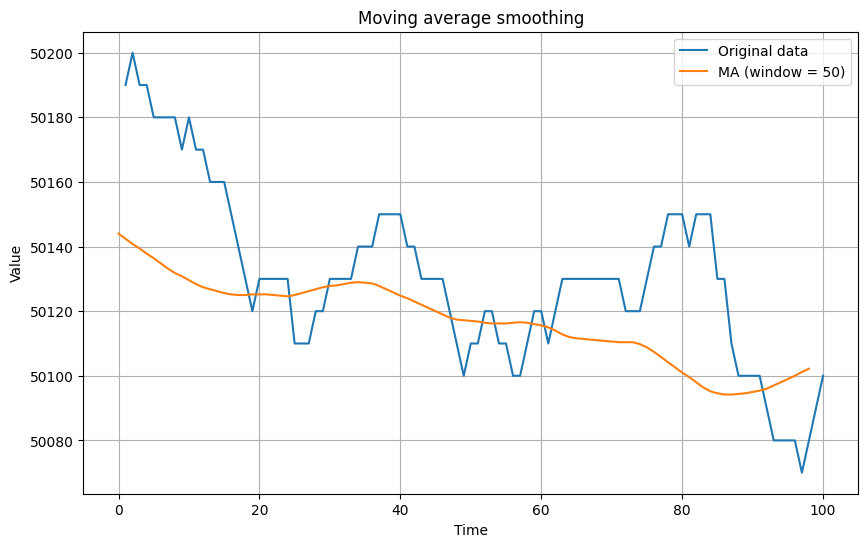

Variance in column 'aaa' changed over time.
Mean in column 'aaa' changed over time.
None


list

In [12]:
def moving_average(data, window):
    n = len(data)
    smoothed_data = [];

    for r, i in enumerate(range(window, n - 1)):
        window_data = data[r : i];
        window_average = sum(window_data) / window
        smoothed_data.append(window_average)

    return smoothed_data

data_ma_sm = rainfall_data_matrix[PREDICT_PARAM]
window_size = 50#WINDOW
smoothed_data = moving_average(data_ma_sm, window_size)



# Побудуємо графіки для порівняння оригінальних даних та згладжених значень
plt.figure(figsize=(10, 6))
# time_ma_sm = rainfall_data_matrix["source_ts"]
# plt.plot(time_ma_sm, data_ma_sm, label='Оригінальні дані')
# plt.plot(time_ma_sm[window_size - 1:], smoothed_data_ma_sm, label=f'МА (вікно = {window_size})')
# plt.plot( data_ma_sm, label='Оригінальні дані')
# plt.plot( smoothed_data, label=f'МА (вікно = {window_size})')

plt.plot( data_ma_sm.loc[1:100], label='Original data')
plt.plot( smoothed_data[1:100], label=f'МА (window = {window_size})')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Moving average smoothing')
plt.grid(True)
plt.show()
# tmp = pd.DataFrame(smoothed_data,'aaa')
# print(check_variance_mean_change(tmp, 'aaa'))
df = pd.DataFrame(smoothed_data, columns =['aaa'])
print(check_variance_mean_change(df,'aaa'))
type(smoothed_data)

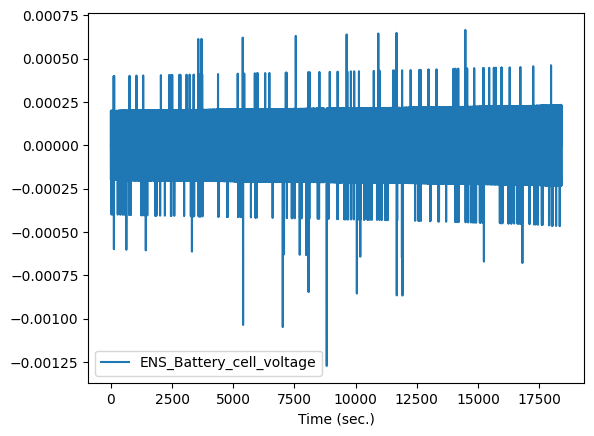

In [26]:
def log_smoth(data, param):
    logxts=np.log(data[param])
    log_data = pd.DataFrame()
    log_data[param]=logxts.diff(1)
    log_data=log_data.dropna() 
    return log_data

dlogxts = log_smoth(rainfall_data_matrix,PREDICT_PARAM)
# dlogxts.plot(marker='o', markersize=3) 

dlogxts.plot()
plt.xlabel('Time (sec.)')
# plt.title('Difference of Logarithm of the ExchRate NZ per UK') 
plt.show()

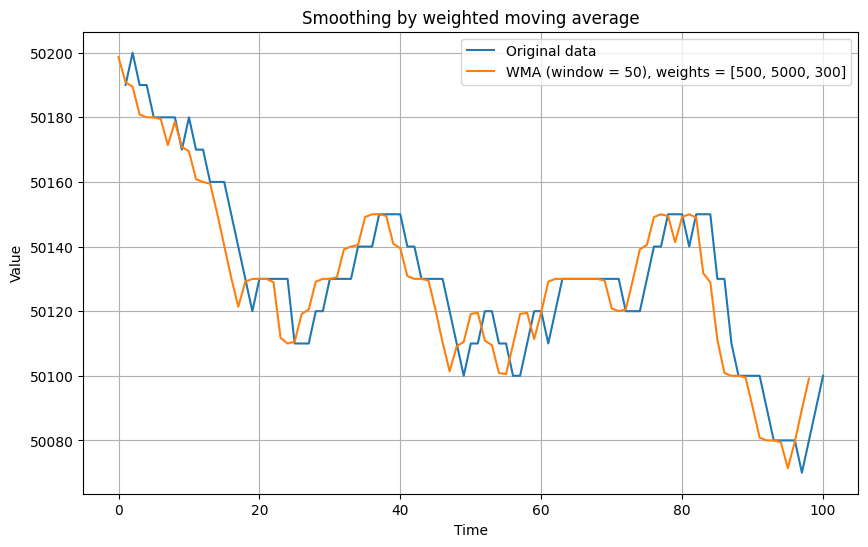

In [5]:
def weighted_moving_average(data, weights):
    n = len(data)
    k = len(weights)
    smoothed_data = []

    for i in range(n - k + 1):
        window_data = data[i:i+k]
        window_average = sum([a * b for a, b in zip(window_data, weights)]) / sum(weights)
        smoothed_data.append(window_average)

    # for r, i in enumerate(range(window, n - 1)):
    #     window_data = data[r : i+k]
    #     window_average = sum([a * b for a, b in zip(window_data, weights)]) / sum(weights)
    #     smoothed_data.append(window_average)

    return smoothed_data


weights = [500, 5000, 300]
# weights = [300, 5000, 500] 
data_wma_sm = rainfall_data_matrix[PREDICT_PARAM]
smoothed_data = weighted_moving_average(data_wma_sm, weights)
# print(smoothed_data)

# rainfall_data_matrix["ENS_Battery_cell_voltage_Wma_Sm"] = 
window_size = 50
# Побудуємо графіки для порівняння оригінальних даних та згладжених значень

plt.figure(figsize=(10, 6))
# time_wma_sm = rainfall_data_matrix["source_ts"]
# plt.plot(time_wma_sm, data_wma_sm, label='Оригінальні дані')
# plt.plot(time_wma_sm[window_size - 1:], smoothed_data, label=f'МА (вікно = {window_size})')
# plt.plot(data_wma_sm, label='Оригінальні дані')
# plt.plot(smoothed_data, label=f'МА (вікно = {window_size})')

plt.plot(data_wma_sm.loc[1:100], label='Original data')
plt.plot(smoothed_data[1:100], label=f'WMA (window = {window_size}), weights = [500, 5000, 300]')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Smoothing by weighted moving average')
plt.grid(True)
plt.show()


ADF Statistic: -11.335364
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary
Variance in column 'ENS_Battery_cell_voltage' changed over time.
Mean in column 'ENS_Battery_cell_voltage' changed over time.
None


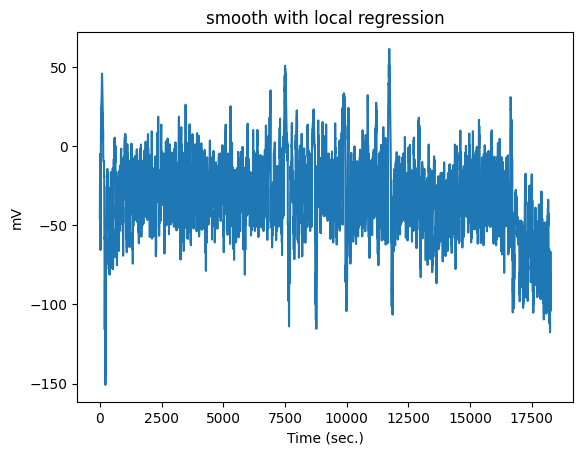

In [17]:

# smoothed_data
new_aver_sign = pd.DataFrame()
tmp_array = [];
for r,i in enumerate(range(WINDOW, len(smoothed_data) - 1)):
    tmp_array.append(rainfall_data_matrix.loc[i,PREDICT_PARAM]-smoothed_data[r])
new_aver_sign[PREDICT_PARAM] = tmp_array;
# plt.title('Згладжування методом зваженого ковзного середнього')
# plt.title('Експоненційне згладжування')
# plt.title('Weighted Moving Average')
# plt.title('Exponential Smoothing (alpha = 0.1)')
# plt.title('Double exponential smoothing (alpha = 0.2, beta = 0.01)')
# plt.title('lowess (tau=0.25)')
plt.title('smooth with local regression')
plt.xlabel('Time (sec.)')
plt.ylabel('mV')
plt.grid(True)
new_aver_sign[PREDICT_PARAM].plot()
check_stationarity(new_aver_sign[PREDICT_PARAM])
print(check_variance_mean_change(new_aver_sign, PREDICT_PARAM))


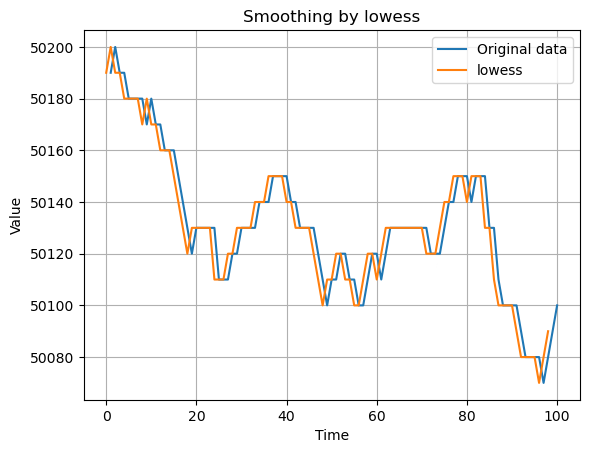

ADF Statistic: 4.827674
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


In [37]:
import numpy as np
from scipy.interpolate import UnivariateSpline

import numpy as np

def lowess(x, y, tau=0.25):
    smoothed_data = np.copy(y)

    for i, xi in enumerate(x):
        distances = np.abs(x - xi)
        weights = np.exp(-0.5 * ((distances / tau) ** 2))
        
        smoothed_data[i] = np.sum(y * weights) / np.sum(weights)

    return smoothed_data

# Load your data
x = rainfall_data_matrix[PREDICT_PARAM].values
dataframe_column = PREDICT_PARAM  # Choose the column name that corresponds to the y values in your DataFrame

# Get the y values from the DataFrame
y = rainfall_data_matrix[dataframe_column].values

# Call the lowess function
smoothed_y = lowess(x, y, tau=.25)

smoothed_data=smoothed_y
# plt.plot(smoothed_y, label='Оригінальні дані')
plt.plot(rainfall_data_matrix.loc[1:100,PREDICT_PARAM], label='Original data')
plt.plot(smoothed_y[1:100], label='lowess')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Smoothing by lowess')
plt.grid(True)
plt.show()

check_stationarity(pd.DataFrame(smoothed_y, columns = ['Column_A']))


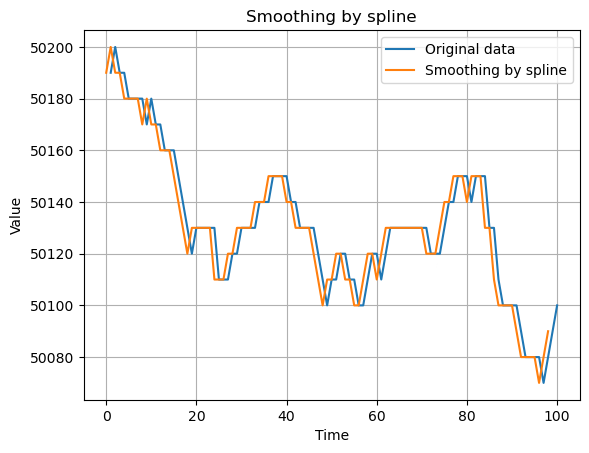

In [44]:
import numpy as np
from scipy.interpolate import UnivariateSpline

def smooth_with_spline(data_column, smoothing_factor):
    """
    data_column: стовпець даних (передавати у вигляді Series з датафрейму)
    smoothing_factor: фактор згладжування (більше значення - більше згладжування)
    """
    x = np.arange(len(data_column))
    y = data_column.values

    spline = UnivariateSpline(x, y, s=smoothing_factor)
    smoothed_data = spline(x)
    
    return smoothed_data.tolist()

# Згладити стовпець 'Value' сплайнами з фактором згладжування 0.5
smoothed_values = smooth_with_spline(rainfall_data_matrix[PREDICT_PARAM], smoothing_factor= 0.01)
# print(smoothed_values)


smoothed_data=smoothed_values

# plt.plot(smoothed_data)
plt.plot(rainfall_data_matrix.loc[1:100,PREDICT_PARAM], label='Original data')
plt.plot(smoothed_data[1:100], label='Smoothing by spline')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Smoothing by spline')
plt.grid(True)
plt.show()

In [ ]:
# smoothed_data

ADF Statistic: 4.463485
p-value: 1.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Non-stationary


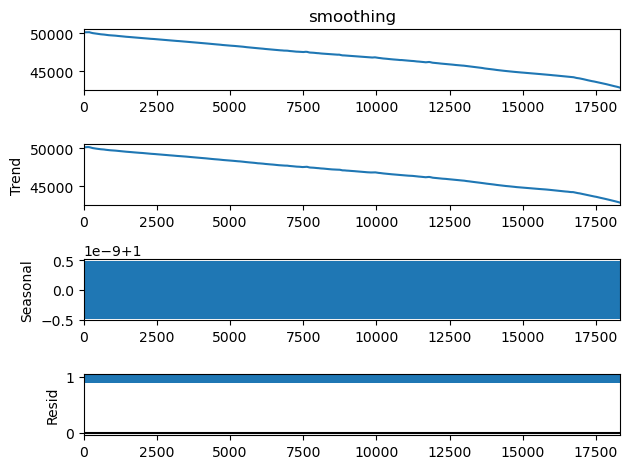

0              NaN
1        50130.500
2        50129.575
3        50128.650
4        50127.800
           ...    
18318    42888.125
18319    42887.325
18320    42886.600
18321    42885.900
18322          NaN
Name: trend, Length: 18323, dtype: float64


In [9]:
df_tmp = pd.DataFrame()
df_tmp['smoothing'] = smoothed_data
check_stationarity(df_tmp['smoothing'])
result = seasonal_decompose(df_tmp['smoothing'], model='multiplicative', period=2)
result.plot()
pyplot.show()
estimated_trend_add = result.trend
estimated_seasonal_add = result.seasonal
estimated_residual_add = result.resid
print(result.trend)


In [10]:
target_data1 = pd.read_csv('rez.csv')#,

target_data1

,ENS_Battery_cell_voltage
0,-31.4
1,-30.5
2,-29.6
3,-18.6
4,-17.8
...,...
18217,-63.4
18218,-72.4
18219,-81.3
18220,-80.1


In [7]:

target_data = smoothed_data
# target_data = tmp # diff
# target_data = differentiated_df['ENS_Battery_cell_voltage']#diff
# target_data = dlogxts
# target_data = target_data1


# target_data = new_aver_sign[PREDICT_PARAM]
# target = smoothed_data # експон згладж
# Масштабування даних
scaler = MinMaxScaler()
target_data = scaler.fit_transform(np.array(target_data).reshape(-1, 1))

# Параметри моделі
n_steps = 5
n_features = 1

# Підготовка даних для моделі RNN
X, y = [], []
for i in range(len(target_data)):
  # Формування вхідних та вихідних даних
    end_ix = i + n_steps  
    if end_ix > len(target_data) - 1:
        break
    seq_x, seq_y = target_data[i:end_ix], target_data[end_ix]
    X.append(seq_x)
    y.append(seq_y)
X, y = np.array(X), np.array(y)

# Розділення на тренувальну та тестову вибірки
split_fraction = 0.8
train_split = int(split_fraction * len(X))
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]
X_pred = X[train_split:len(target_data)]
y_pred = y[train_split:len(target_data)]


In [8]:
print(train_split)
print(X_train.shape,' ',y_train.shape,' ',X_test.shape,' ',y_test.shape,' ',X_pred.shape,' ',y_pred.shape)

14733
(14733, 5, 1)   (14733, 1)   (3684, 5, 1)   (3684, 1)   (3684, 5, 1)   (3684, 1)


In [9]:
print(n_steps,' ',n_features)

5   1


In [10]:
import time
from keras.utils import plot_model
start = time.time()
# Створення моделі RNN
model = Sequential()
# my_model_G4_12_100_13_1.h5 Test MAE: 35.76 Test MSE: 2240.76 MAPE:  0.0 % R2= 0.7902434739337205 9.98  min
# my_model_G3_12_100_13_1.h5 Test MAE: 33.98 Test MSE: 1721.97 MAPE:  0.0 % R2= 0.8388073288641628 9.23  min
# 'my_model_G2_12_100_13_1.h5'Test MAE: 38.74 Test MSE: 2494.79 MAPE:  0.0 % R2= 0.7664637268406054 9.03  min
model.add(SimpleRNN(12, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

# Виведення графіку архітектури нейромережі
plot_model(model, to_file='neural_network.png', show_shapes=True, show_layer_names=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 12)                168       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 181 (724.00 Byte)
Trainable params: 181 (724.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
# Компіляція моделі
model.compile(optimizer='adam', loss='mse')

# Тренування моделі
# model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)
# model.fit(X_train, y_train, epochs=20, batch_size=BATCH_SIZE, verbose=1)#
model.fit(X_train, y_train, epochs=EPOHS, batch_size=BATCH_SIZE, verbose=1)


Epoch 1/100
1228/1228 [==============================] - 1s 409us/step - loss: 0.0027
Epoch 2/100
1228/1228 [==============================] - 0s 402us/step - loss: 1.2424e-04
Epoch 3/100
1228/1228 [==============================] - 1s 417us/step - loss: 3.5247e-05
Epoch 4/100
1228/1228 [==============================] - 0s 407us/step - loss: 1.7612e-05
Epoch 5/100
1228/1228 [==============================] - 0s 394us/step - loss: 1.2098e-05
Epoch 6/100
1228/1228 [==============================] - 0s 403us/step - loss: 8.4644e-06
Epoch 7/100
1228/1228 [==============================] - 0s 394us/step - loss: 7.7462e-06
Epoch 8/100
1228/1228 [==============================] - 0s 395us/step - loss: 6.6455e-06
Epoch 9/100
1228/1228 [==============================] - 1s 410us/step - loss: 5.6850e-06
Epoch 10/100
1228/1228 [==============================] - 1s 411us/step - loss: 5.1757e-06
Epoch 11/100
1228/1228 [==============================] - 0s 395us/step - loss: 5.3651e-06
Epoch 12/100

In [12]:

# Оцінка точності моделі на тестовій вибірці
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score}')

Test loss: 0.0005502458661794662


In [13]:
#new_data = np.array([[0.4, 0.3, 0.2, 0.1, 0.0], [0.9, 0.8, 0.7, 0.6, 0.5]])
# new_data = scaler.transform(new_data.reshape(-1, n_steps, n_features).reshape(-1, n_features))
# new_data = new_data.reshape(2, n_steps, n_features)
new_data = X_pred
predictions = model.predict(new_data)
predictions = scaler.inverse_transform(predictions)
#print(f'Predictions: {predictions}')
end = time.time()
print(start,' ',end)
Training_Speed = round(((end-start)/60),2)
print(Training_Speed,' min')

116/116 [==============================] - 0s 301us/step
1694785724.324279   1694785775.3636851
0.85  min


116/116 [==============================] - 0s 326us/step


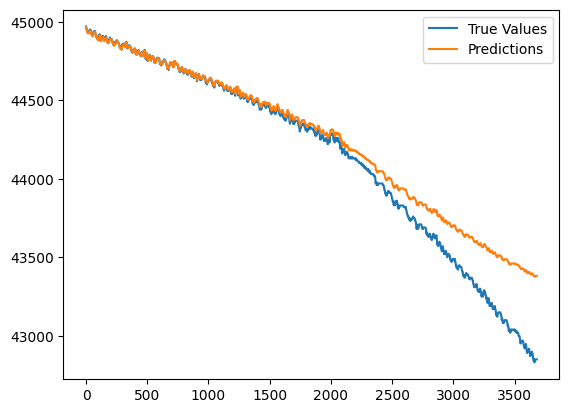

MAPE= 0.002358739416051931
RMSE= 172.83595335573824
MSPE= 1.603875449147328e-05
RMSPE= 0.4004841381562231
MFE= -100.52579197759893
MBE= -100.52579197759893
SEBIAS= -370337.01764547447
ME= 549.1808997844855
R2= 0.9165044650358226


In [14]:
import math 
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score, mean_absolute_percentage_error

# Отримання прогнозів на тестовій вибірці
y_pred = model.predict(X_test)

# Обернення масштабування
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Виведення графіку
plt.plot(y_test_inv, label='True Values')

plt.plot(y_pred_inv, label='Predictions')
plt.legend()
plt.show()

print('MAPE=',mean_absolute_percentage_error(y_test_inv, y_pred_inv))
print('RMSE=',root_mean_squared_error(y_test_inv, y_pred_inv))
print('MSPE=',mean_squared_persentage_error(y_test_inv, y_pred_inv))
print('RMSPE=',root_mean_squared_persentage_error(y_test_inv, y_pred_inv))
print('MFE=',mean_forecast_error(y_test_inv, y_pred_inv))
print('MBE=',mean_bias_error(y_test_inv, y_pred_inv))
print('SEBIAS=',systematic_error_BIAS(y_test_inv, y_pred_inv))
print('ME=',max_error_(y_test_inv, y_pred_inv))
print('R2=',r2_e(y_test_inv, y_pred_inv))


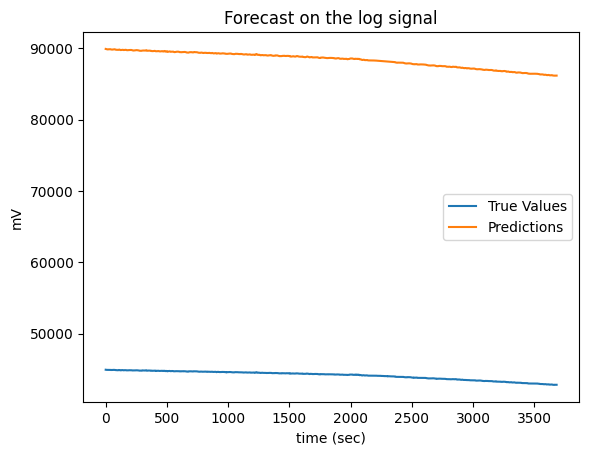

MAPE= 1.002075637907272
RMSE= 44238.54573979314
MSPE= 1.0041644969887578
RMSPE= 100.20800851173313
MFE= -44235.939663070036
MBE= -44235.939663070036
SEBIAS= -162965201.71875
ME= 44963.5625
R2= -5464.758502589953


/opt/homebrew/Caskroom/miniconda/base/envs/m2cnd-tf-pd2-p3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
count = len(y_pred_inv)
type(rainfall_data_matrix)
data_ma_sm = rainfall_data_matrix.loc[:,PREDICT_PARAM]

mean = pd.Series(data_ma_sm[-count:].values)
noise = pd.Series(y_pred_inv.transpose()[0])
simulation = mean+noise
# print(simulation)#,' =', mean,' ', noise)
# simulation.plot()
# Виведення графіку
plt.plot(data_ma_sm[-count:].values, label='True Values')
plt.plot(simulation, label='Predictions')
plt.legend()
plt.xlabel('time (sec)')
plt.ylabel('mV')
plt.title('Forecast on the log signal')
plt.show()

print('MAPE=',mean_absolute_percentage_error(data_ma_sm[-count:].values, simulation))
print('RMSE=',root_mean_squared_error(data_ma_sm[-count:].values, simulation))
print('MSPE=',mean_squared_persentage_error(data_ma_sm[-count:].values, simulation))
print('RMSPE=',root_mean_squared_persentage_error(data_ma_sm[-count:].values, simulation))
print('MFE=',mean_forecast_error(data_ma_sm[-count:].values, simulation))
print('MBE=',mean_bias_error(data_ma_sm[-count:].values, simulation))
print('SEBIAS=',systematic_error_BIAS(data_ma_sm[-count:].values, simulation))
print('ME=',max_error_(data_ma_sm[-count:].values, simulation))
print('R2=',r2_e(data_ma_sm[-count:].values, simulation))
model.save('RNN_lowess.h5')

In [25]:
# print(type(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]),' ',len(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]))
# print(type(y_pred_inv), len(y_pred_inv))
# pd.Series(y_pred_inv.transpose()[0])

# # for r, i in enumerate(len(smoothed_data)-len(y_pred_inv), len(smoothed_data)):
#     # sd[r] = smoothed_data[i]
# print(len(smoothed_data)-len(y_pred_inv)  )    
# len(y_pred_inv)

In [ ]:
# savetxt('rez_o.csv',smoothed_data[len(smoothed_data)-len(y_pred_inv)-1:len(smoothed_data)], delimiter=',')
# target_data2= pd.DataFrame()
# target_data2= pd.read_csv('rez_o.csv')#,
# type(target_data2)
# # target_data2

In [ ]:
# count = len(y_pred_inv)
# print(len(pd.Series(rainfall_data_matrix.loc[-count:,PREDICT_PARAM].values)))
# pd.Series(rainfall_data_matrix.loc[-count:,PREDICT_PARAM].values)

In [ ]:
# count = len(y_pred_inv)
# mean = pd.Series(rainfall_data_matrix[-count:,].values)
# noise = pd.Series(y_pred_inv.transpose()[0])
# simulation = mean+noise
# print(simulation)#,' =', mean,' ', noise)
# # simulation.plot()
# # Виведення графіку
# plt.plot(data_ma_sm[-count:].values, label='True Values')
# plt.plot(simulation, label='Predictions')
# plt.legend()
# plt.xlabel('time (sec)')
# plt.ylabel('mV')
# plt.title('Forecast on the centered signal')
# plt.show()

In [ ]:
# target_data2.rename(columns = {'4.493333333333333576e+04':'smooth'},inplace = True)
# print(target_data2+y_pred_inv)
# origin_pred_sign = target_data2+y_pred_inv

# origin_pred_sign.plot()
# plt.show()

# (pd.Series(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM])).plot()
# tmp = rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM]
# rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM].plot()
# plt.show()
# tmp.plot()

# # print(type(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]),' ',len(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]))
# # print(type(y_pred_inv), len(y_pred_inv))
# # pd.Series(y_pred_inv.transpose()[0])
# # (rainfall_data_matrix.loc[-len(origin_pred_sign),PREDICT_PARAM], origin_pred_sign)
# print('MAPE=',mean_absolute_percentage_error(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('RMSE=',root_mean_squared_error(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('MSPE=',mean_squared_persentage_error(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('RMSPE=',root_mean_squared_persentage_error(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('MFE=',mean_forecast_error(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('MBE=',mean_bias_error(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('SEBIAS=',systematic_error_BIAS(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('ME=',max_error_(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))
# print('R2=',r2_e(rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM], origin_pred_sign))

In [ ]:
rainfall_data_matrix.loc[rainfall_data_matrix.shape[0]-len(origin_pred_sign):rainfall_data_matrix.shape[0],PREDICT_PARAM]
# rainfall_data_matrix.shape[0]

In [ ]:
# print(type(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]),' ',len(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]))
# print(type(y_pred_inv), len(y_pred_inv))
# pd.Series(y_pred_inv.transpose()[0])

# # for r, i in enumerate(len(smoothed_data)-len(y_pred_inv), len(smoothed_data)):
# #     print('aa')
#     # sd[r] = smoothed_data[i]
# type(len(smoothed_data)-len(y_pred_inv) )       
# # len(y_pred_inv)
# # type(len(smoothed_data)-len(y_pred_inv))

# # smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]
# # smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]

# # print(len(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]))
# # plt.plot(data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1], label='True Values')
# # plt.show()
# # plt.plot(y_pred_inv, label='Predictions')
# # plt.legend()
# # plt.show()
# # 
# # print(pd.Series(y_pred_inv.transpose()[0]),'+',len(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]),'=', pd.Series(y_pred_inv.transpose()[0])+len(smoothed_data[len(smoothed_data)-len(y_pred_inv):len(smoothed_data)]))

In [ ]:
# Виведення графіку

# plt.plot(data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1], label='True Values')
# plt.show()
# plt.plot(y_pred_inv, label='Predictions')
# plt.legend()
# plt.show()

In [ ]:
# print(type(data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1]))
# print(data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1].values)
# savetxt('y_pred_inv.csv', y_pred_inv, header = 'aaa', delimiter=',')
# import pandas as pd
# print(type(y_pred_inv))
# print(y_pred_inv[2])
# df1 = pd.read_csv('y_pred_inv.csv')
# # df1
# # df1 = pd.DataFrame(y_pred_inv, columns = ['Column_A'])

# # print( data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1].values+target_data2.iloc[:,1].values)
# # print(data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1].values)
# # print(target_data2.iloc[:,1].values)

In [ ]:

# print(data_ma_sm.iloc[len(data_ma_sm)-len(y_pred_inv):len(data_ma_sm)-1].values)
# pd.Series(y_pred_inv.transpose()[0])
# # print(type(y_pred_inv))
# # y_pred_inv.transpose()[0]
# len(y_pred_inv)

0       44960.194913
1       44960.194913
2       44960.194913
3       44960.194913
4       44950.194913
            ...     
3679    42850.194913
3680    42850.194913
3681    42850.194913
3682    42850.194913
3683    42850.194913
Length: 3684, dtype: float64


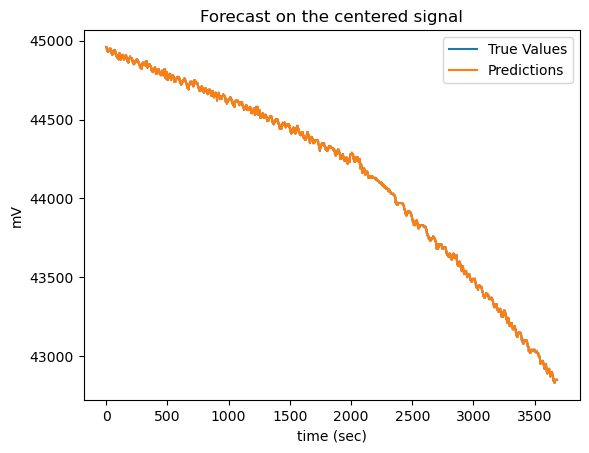

In [20]:
count = len(y_pred_inv)


mean = pd.Series(data_ma_sm[-count:].values)
noise = pd.Series(y_pred_inv.transpose()[0])
simulation = mean+noise
print(simulation)#,' =', mean,' ', noise)
# simulation.plot()
# Виведення графіку
plt.plot(data_ma_sm[-count:].values, label='True Values')
plt.plot(simulation, label='Predictions')
plt.legend()
plt.xlabel('time (sec)')
plt.ylabel('mV')
plt.title('Forecast on the centered signal')
plt.show()



In [ ]:
print('MAPE=',mean_absolute_percentage_error(data_ma_sm[-count:].values, simulation))
print('RMSE=',root_mean_squared_error(data_ma_sm[-count:].values, simulation))
print('MSPE=',mean_squared_persentage_error(data_ma_sm[-count:].values, simulation))
print('RMSPE=',root_mean_squared_persentage_error(data_ma_sm[-count:].values, simulation))
print('MFE=',mean_forecast_error(data_ma_sm[-count:].values, simulation))
print('MBE=',mean_bias_error(data_ma_sm[-count:].values, simulation))
print('SEBIAS=',systematic_error_BIAS(data_ma_sm[-count:].values, simulation))
print('ME=',max_error_(data_ma_sm[-count:].values, simulation))
print('R2=',r2_e(data_ma_sm[-count:].values, simulation))

In [27]:
import pandas as pd
print( type(data_ma_sm),' ',type(target_data2))
tmp = pd.DataFrame()

<class 'pandas.core.series.Series'>   <class 'pandas.core.frame.DataFrame'>


In [22]:
np.savetxt("Rezults/RNN_ERRORS/RNN_MA2_predictions100_12_centr_or_2"+str(EPOHS)+'_'+str(BATCH_SIZE)+".txt", y_pred_inv, delimiter=",")

with open('Rezults/RNN_ERRORS/RNN_MA2_predictions100_12_centr_or_2'+str(EPOHS)+'_'+str(BATCH_SIZE)+'.txt', 'a') as f:
    f.writelines(f'TRAIN_COUNT = {TRAIN_COUNT}, VALID_COUNT = {VALID_COUNT}, PREDICT_COUNT = {PREDICT_COUNT}, split_fraction = {split_fraction}, epochs = {EPOHS} , batch_size={BATCH_SIZE}, window={WINDOW} \n')
    f.writelines(f'MAPE: {mean_absolute_percentage_error(y_test_inv, y_pred_inv):.4f}, RMSE: {root_mean_squared_error(y_test_inv, y_pred_inv):.4f}')
    f.writelines(f', MSPE: {mean_squared_persentage_error(y_test_inv, y_pred_inv):.4f}, RMSPE: {root_mean_squared_persentage_error(y_test_inv, y_pred_inv):.4f}')
    f.writelines(f', MFE: {mean_forecast_error(y_test_inv, y_pred_inv):.4f}, MBE: {systematic_error_BIAS(y_test_inv, y_pred_inv):.4f}')
    f.writelines(f', R2: {r2_e(y_test_inv, y_pred_inv):.4f},  time (min):{Training_Speed:.4f}\n')


In [16]:
# save model in file
# model.save('my_model_ES5_0.01_100_100_12_1.h5')
model.save('RNN_Kov_ser_1.h5')

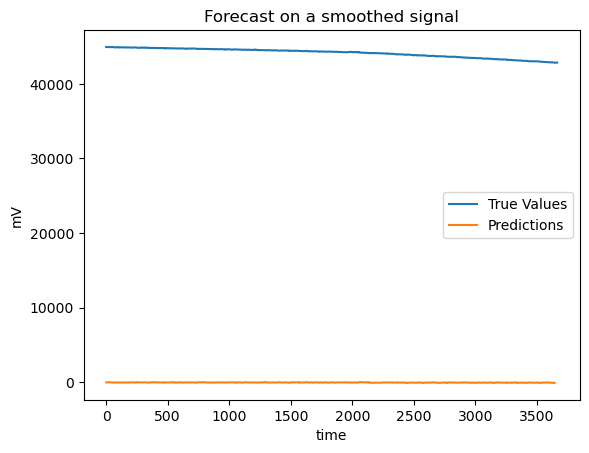

MAPE= 4154764135050.038
RMSE= 5.709196811648468
MSPE= 9.935349891416421e+16
RMSPE= 31520390053.76745
MFE= -0.7687169135348892
MBE= -0.7687169135348892
SEBIAS= -2801.2044329211362
ME= 30.259213638302754
R2= 0.9205736082523824


In [140]:

# target_col_idx = 'ENS_Battery_cell_voltage'
# target_data = data.loc[:, target_col_idx]
target_data = rainfall_data_matrix["ENS_Battery_cell_voltage"]
# Масштабування даних
scaler = MinMaxScaler()
target_data = scaler.fit_transform(np.array(target_data).reshape(-1, 1))

# Підготовка даних для моделі RNN
X, y = [], []
for i in range(len(target_data)):
  # Формування вхідних та вихідних даних
    end_ix = i + n_steps  
    if end_ix > len(target_data) - 1:
        break
    seq_x, seq_y = target_data[i:end_ix], target_data[end_ix]
    X.append(seq_x)
    y.append(seq_y)
X, y = np.array(X), np.array(y)

# Розділення на тренувальну та тестову вибірки
split_fraction = 0.8
train_split = int(split_fraction * len(X))

y_test = y[train_split+20:]

# Виведення графіку
plt.plot(scaler.inverse_transform(y_test), label='True Values')
plt.plot(y_pred_inv, label='Predictions')
plt.legend()
plt.xlabel('time')
plt.ylabel('mV')
plt.title('Forecast on a smoothed signal')
plt.show()
print('MAPE=',mean_absolute_percentage_error(y_test_inv, y_pred_inv))
print('RMSE=',root_mean_squared_error(y_test_inv, y_pred_inv))
print('MSPE=',mean_squared_persentage_error(y_test_inv, y_pred_inv))
print('RMSPE=',root_mean_squared_persentage_error(y_test_inv, y_pred_inv))
print('MFE=',mean_forecast_error(y_test_inv, y_pred_inv))
print('MBE=',mean_bias_error(y_test_inv, y_pred_inv))
print('SEBIAS=',systematic_error_BIAS(y_test_inv, y_pred_inv))
print('ME=',max_error_(y_test_inv, y_pred_inv))
print('R2=',r2_e(y_test_inv, y_pred_inv))